### COSC102 Assignment 3 - Prepare Data
The purpose of this notebook is to prepare the data for the model training.
We will use the data from the IMU sensor to train a model to predict the activity of the user.



In [1]:

import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
import dtreeviz

# Set some lists to store the IMU data.

time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []

def map_activity(activity_string):
    if activity_string == 'Standing':
        return 0
    elif activity_string == 'Walking':
        return 1
    elif activity_string == 'Jogging':
        return 2
    elif activity_string == 'Side-Step':
        return 3
    elif activity_string == 'Running':
        return 4


In [2]:
# Read the IMU data from the csv file.
with open ('./datasets/a3_imu_data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        time_track.append(float(row[0]));
        ax_set.append(float(row[1]))
        ay_set.append(float(row[2]))
        az_set.append(float(row[3]))
        gx_set.append(float(row[4]))
        gy_set.append(float(row[5]))
        gz_set.append(float(row[6]))

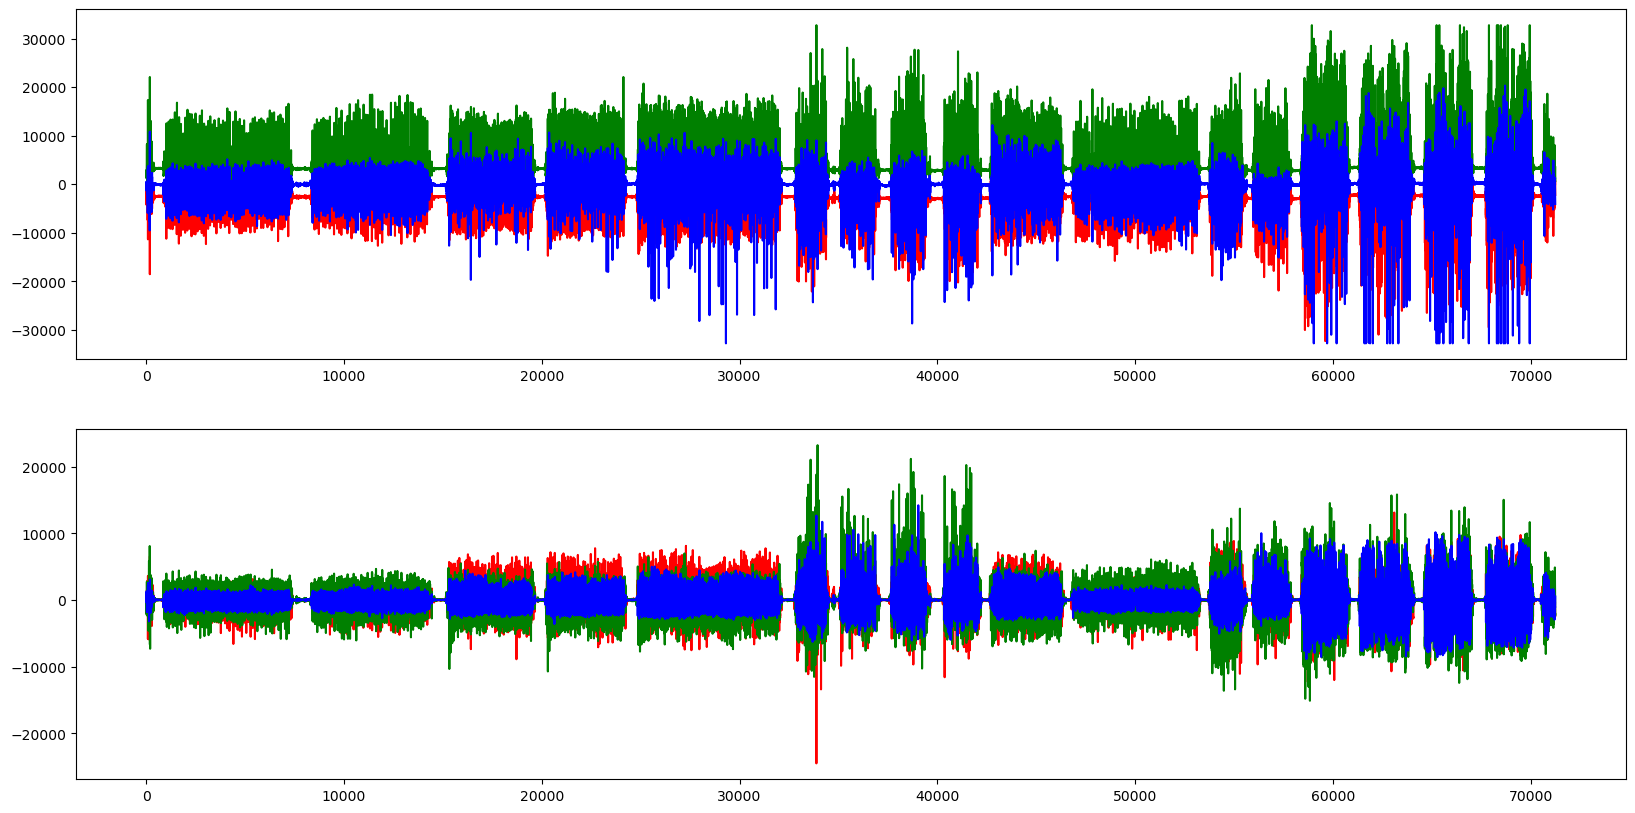

In [3]:
# Check the raw IMU data from the csv file.

fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')

start_ts:  1598240221.0


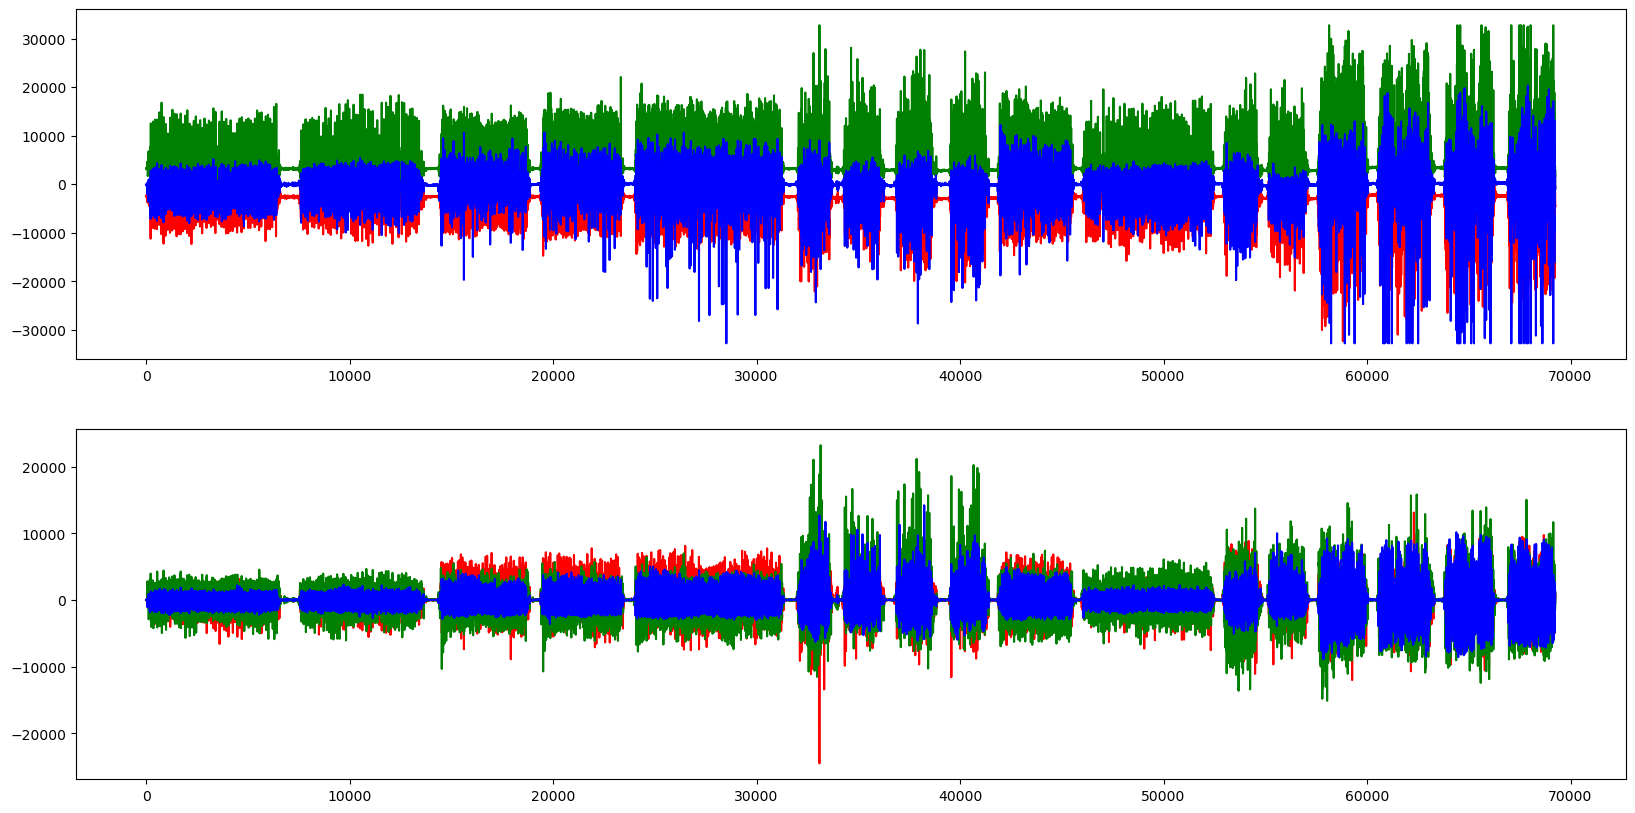

In [4]:
start_idx = 800

start_ts = time_track[start_idx]
print('start_ts: ', start_ts)

end_idx = time_track.index(start_ts + 711)

# Sanity Check
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')

In [5]:

# Add activity annotation to the IMU data from the csv file.
with open ('./datasets/a3_activity_annotations.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # skip the headers
    for row in reader:
        time_stamp = (row[0].split('='))[1]
        activity_set.append([float(time_stamp),row[-1], map_activity(row[-1])])

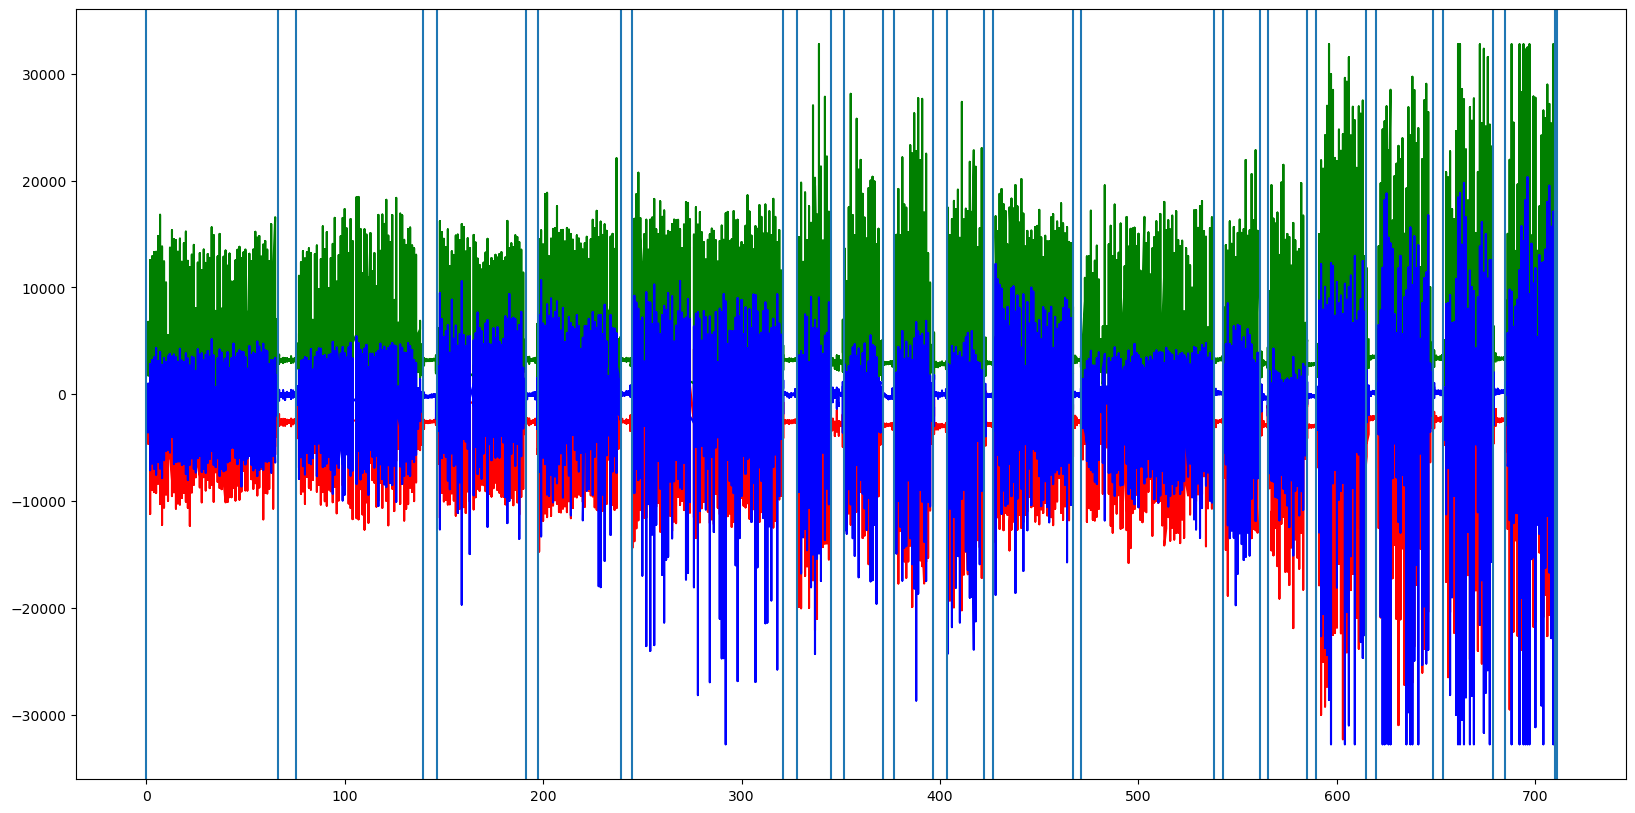

In [6]:
# Now we can create an activity time track for each data point within
# the imu timeseries. We will have a list to store the numeric code and the string.
activity_timeseries = [];
activity_string_timeseries = [];
activity_idx = 0;

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

# #Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time

ig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')


for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        #Move to nex activity
        activity_idx = activity_idx + 1;
        next_activity_ts = activity_set[activity_idx+1][0]
    
    
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act))

(array([ 8892., 19341., 19496., 11303., 10218.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

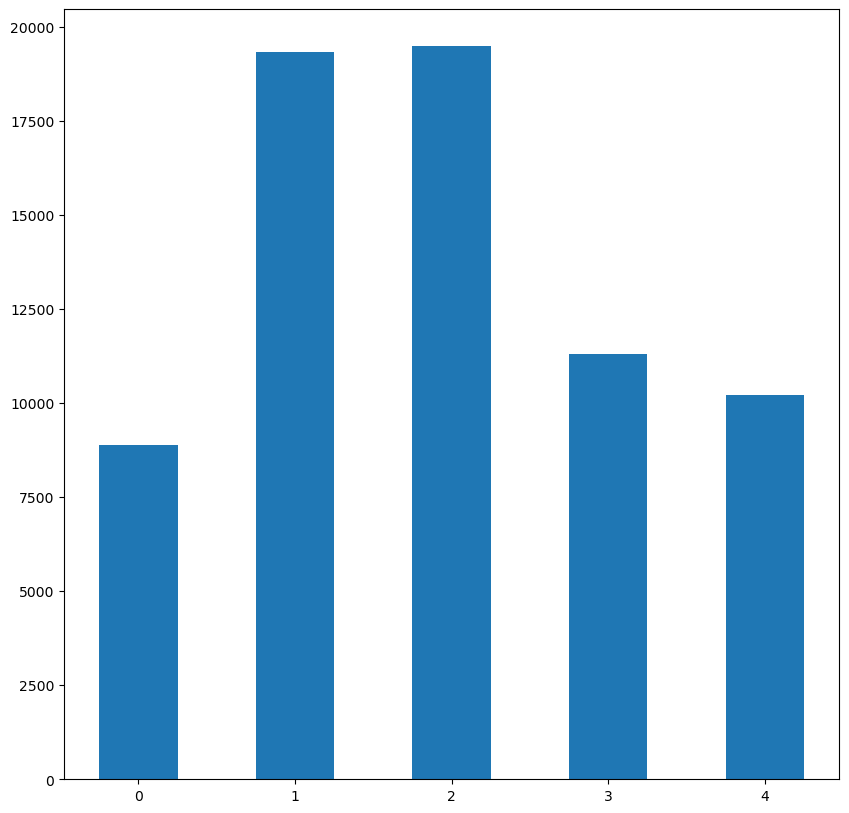

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(activity_timeseries, bins=[-0.5,0.5,1.5,2.5,3.5, 4.5] , rwidth=0.5, align='mid')

In [8]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

In [9]:
# Now we can start working on the machine learning workflow.
# The first step is to calculate some feature that we can use.
# We will base our analysis around a moving window across the
# the timeseries data. This involves taking a fixed length window, based upon the time, and
# sliding it across the data.
# To keep thing simple, we will start with a 1 second window with no overlapping
# data points

feature_set = []
target_set  = []            
window_size = 1.0;
bad_data_point = [104, 105, 163, 164, 274, 275]            

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    
    #There is a missing data-point (probably due to a bad segment on the SD card)
    
    if t in bad_data_point:
      continue
    
    #The index function finds the index of the first occurnace of the data
    window_start_idx = list(time_track_segment).index(t)
    window_end_idx = list(time_track_segment).index(t+window_size)
    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]

    # Now we can build features from the data window
    # Mean
    mu_ax = statistics.mean(ax_window)
    mu_ay = statistics.mean(ay_window)
    mu_az = statistics.mean(az_window)
    mu_gx = statistics.mean(gx_window)
    mu_gy = statistics.mean(gy_window)
    mu_gz = statistics.mean(gz_window)
    
    # Max
    max_ax = max(ax_window)
    max_ay = max(ay_window)
    max_az = max(az_window)
    max_gx = max(gx_window)
    max_gy = max(gy_window)
    max_gz = max(gz_window)
    
    # Min
    min_ax = min(ax_window)
    min_ay = min(ay_window)
    min_az = min(az_window)
    min_gx = min(gx_window)
    min_gy = min(gy_window)
    min_gz = min(gz_window)
    
    ax_abs_sum = 0
    ay_abs_sum = 0
    az_abs_sum = 0
    
    gx_abs_sum = 0
    gy_abs_sum = 0
    gz_abs_sum = 0
    
    a_sum_sq = 0
    g_sum_sq = 0
    
    # Here we need to accumulate the values to calculate the SMA and AI
    for i in range(0, len(ax_window)):
        
        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])
        
        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])
        
        
        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq
    
    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)


    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz, \
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz, \
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz, \
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)



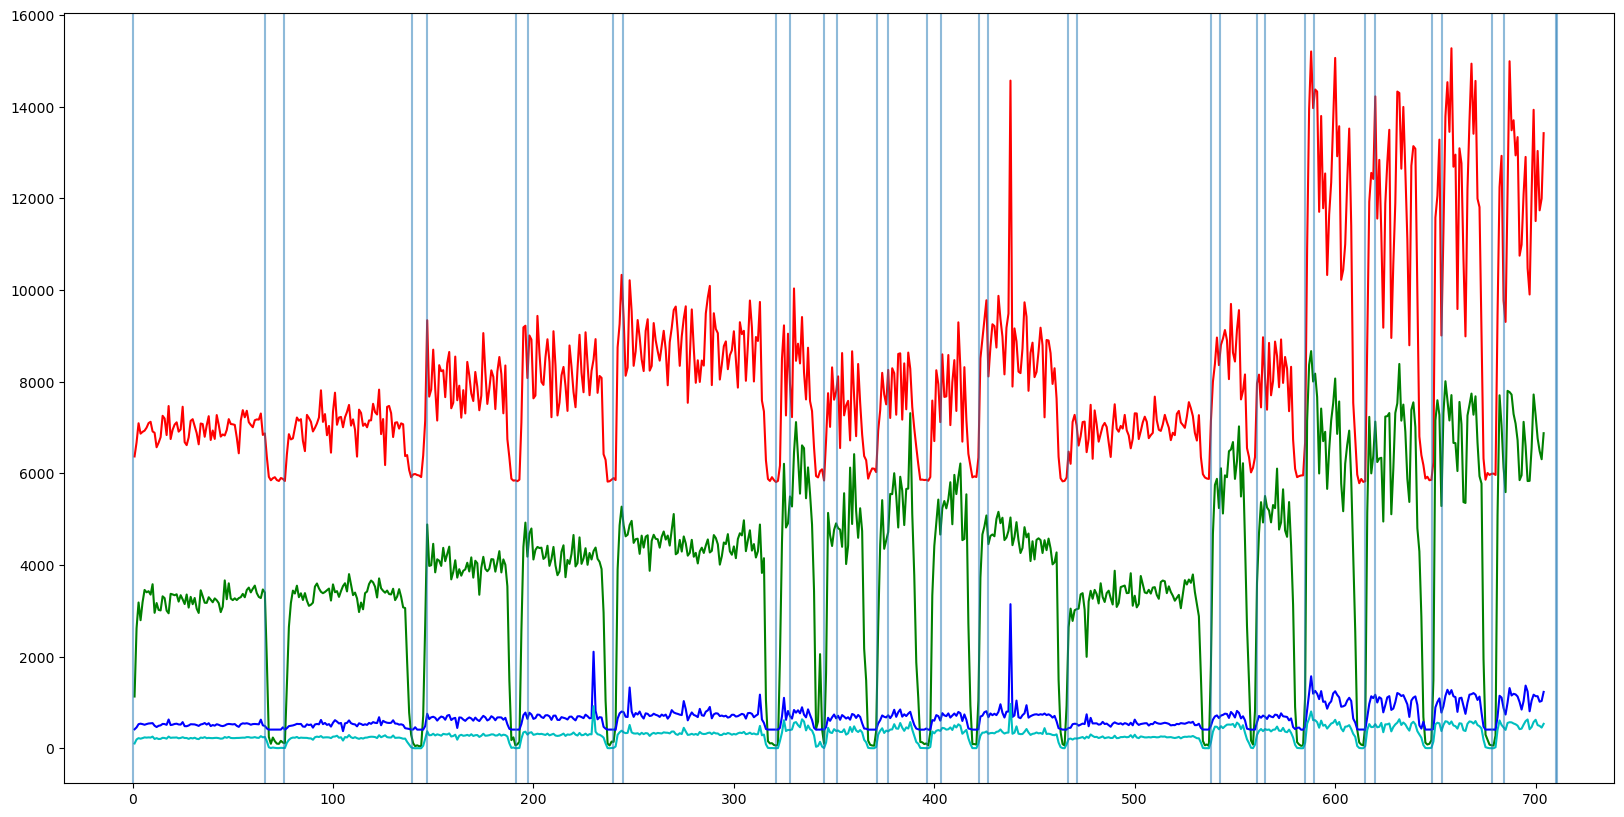

In [10]:
# Lets visualise some of the features just out of interest - we will look at the SMA and AI
plot_range = range(1,705)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(plot_range,np.array(feature_set)[:,18], color='r')
ax.plot(plot_range,np.array(feature_set)[:,19], color='g')
ax.plot(plot_range,np.array(feature_set)[:,20], color='b')
ax.plot(plot_range,np.array(feature_set)[:,21], color='c')

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act), alpha=0.5)
    

CV Train Recall: [0.85483871 0.91447368 0.94557823 0.89655172 0.8125    ]
CV Train Precision: [0.84126984 0.87421384 0.93288591 0.88636364 0.94202899]
CV Train F1 Score: [0.848      0.89389068 0.93918919 0.89142857 0.87248322]
Test Recall: [0.89655172 1.         0.92307692 0.81481481 0.83333333]
Test Precision: [0.92857143 0.84615385 0.94117647 0.88       1.        ]
Test F1 Score: [0.9122807  0.91666667 0.93203883 0.84615385 0.90909091]


/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Text(0.5, 1.0, 'Testing Set')

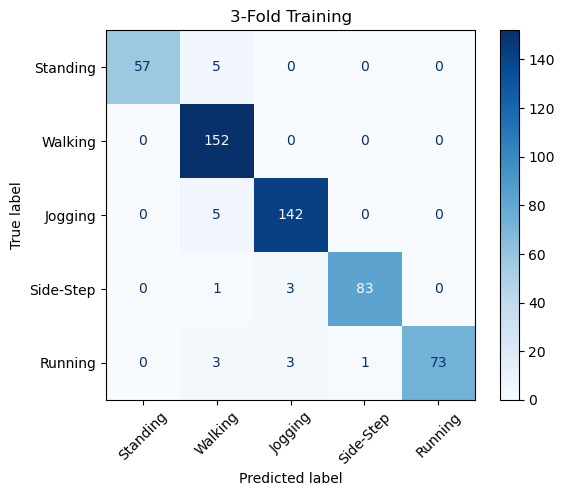

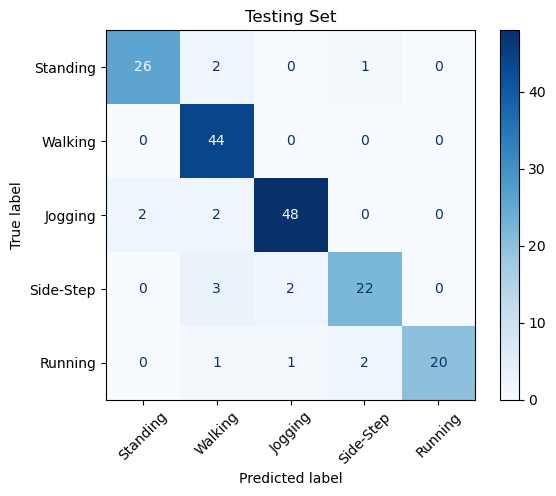

In [11]:
# Now we can apply a classifier - we will use a simple Decision Tree classifier for this demo.            
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set)
# Set the number neightbours to use in the classifier
#n_neighbors = 10
# we create an instance of Neighbours Classifier and fit the data.
#clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')

# Train
clf = DecisionTreeClassifier(max_depth=4)

clf.fit(X_train, y_train)
# Return the predictions for the 3-Fold crossvalidation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)
# Construct the confusion matricies
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# Print out the recall, precision and F1 scores
# There will be a value for each class
# CV Train
print("CV Train Recall:", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:",f1_score(y_train,y_predicted,average=None))

# Test
print("Test Recall:",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:",f1_score(y_test,y_test_predicted,average=None))

# Plot the confusion matrices using the pretty functions
fig, ax = plt.subplots()
disp = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=['Standing', 'Walking','Jogging', 'Side-Step','Running'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('3-Fold Training')

fig, ax = plt.subplots()
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Standing', 'Walking','Jogging', 'Side-Step','Running'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('Testing Set')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


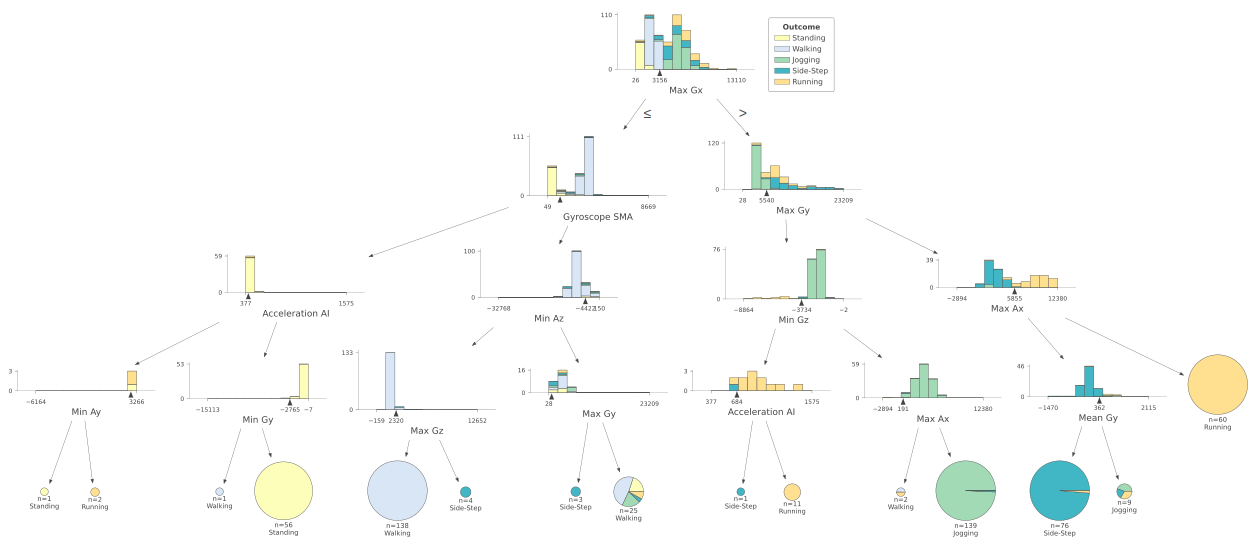

In [12]:
# Class names - I used a dictionary structure because the dtreeviz module was playing up with a list
c_names = {0:"Standing", 1:"Walking", 2:"Jogging", 3:"Side-Step", 4:"Running"}
# Feature names for the tree.
f_names = ["Mean Ax", "Mean Ay", "Mean Az","Mean Gx", "Mean Gy", "Mean Gz",
           "Max Ax", "Max Ay", "Max Az","Max Gx", "Max Gy", "Max Gz", 
           "Min Ax", "Min Ay", "Min Az","Min Gx", "Min Gy", "Min Gz",
           "Acceleration SMA", "Gyroscope SMA" , "Acceleration AI", "Gyroscope AI"]

# Visualise the best classifier using dtreeviz
viz = dtreeviz.model(clf, 
     np.array(X_train), 
     np.array(y_train),
     target_name ='Outcome',
     feature_names = f_names,
     class_names = c_names
    )  
              
viz.view() 

Best depth:  6
Best score:  0.919937036398137


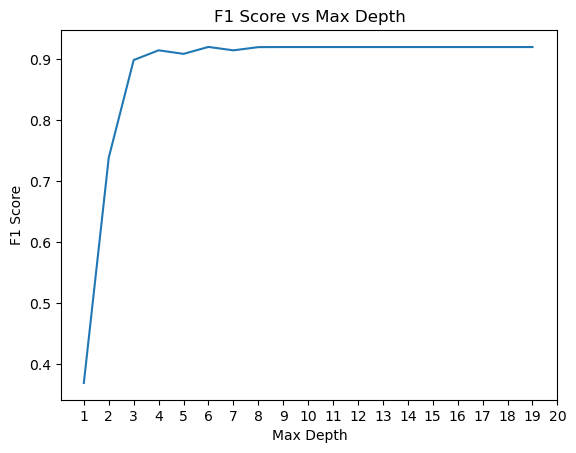

/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


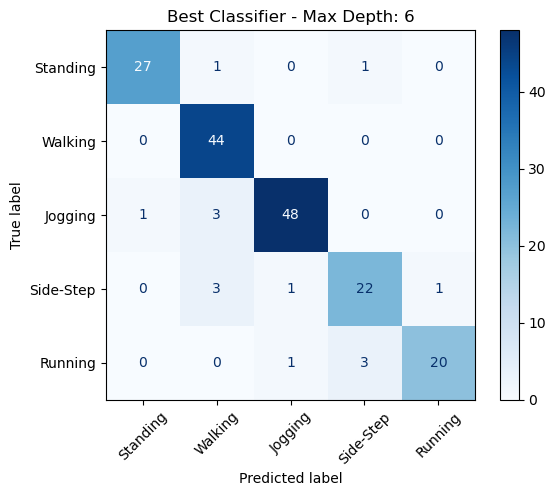

In [39]:
# Optimise a hyperparameter - max_depth

f1_scores = []
best_score = 0
best_depth = 1
depth_range = range(1,20)

for depth in depth_range:

  clf = DecisionTreeClassifier(max_depth=depth, random_state=66)
  clf.fit(X_train, y_train)
  # Return the predictions for the 5-Fold crossvalidation
  y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
  # Return the predictions for the test set
  y_test_predicted = clf.predict(X_test)

  # Test
  score = f1_score(y_test,y_test_predicted,average='weighted')
  f1_scores.append(score)
  if score > best_score:
    best_score = score
    best_depth = depth


# Plot the F1 score vs the max depth

print("Best depth: ", best_depth)
print("Best score: ", best_score)
plt.plot(depth_range, f1_scores)
plt.xlabel('Max Depth')
plt.xticks(np.arange(1, 21, 1))
plt.ylabel('F1 Score')
plt.title('F1 Score vs Max Depth')
plt.show()

# Train the best classifier
clf = DecisionTreeClassifier(max_depth=best_depth)
clf.fit(X_train, y_train)
# Return the predictions for the 3-Fold crossvalidation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)

# Plot confusion matrix for the best classifier
fig, ax = plt.subplots()
title_text = 'Best Classifier - Max Depth: ' + str(best_depth)
ax.title.set_text(title_text)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                  display_labels=['Standing', 'Walking','Jogging', 'Side-Step','Running'],
                                  cmap=plt.cm.Blues,ax=ax)  
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)




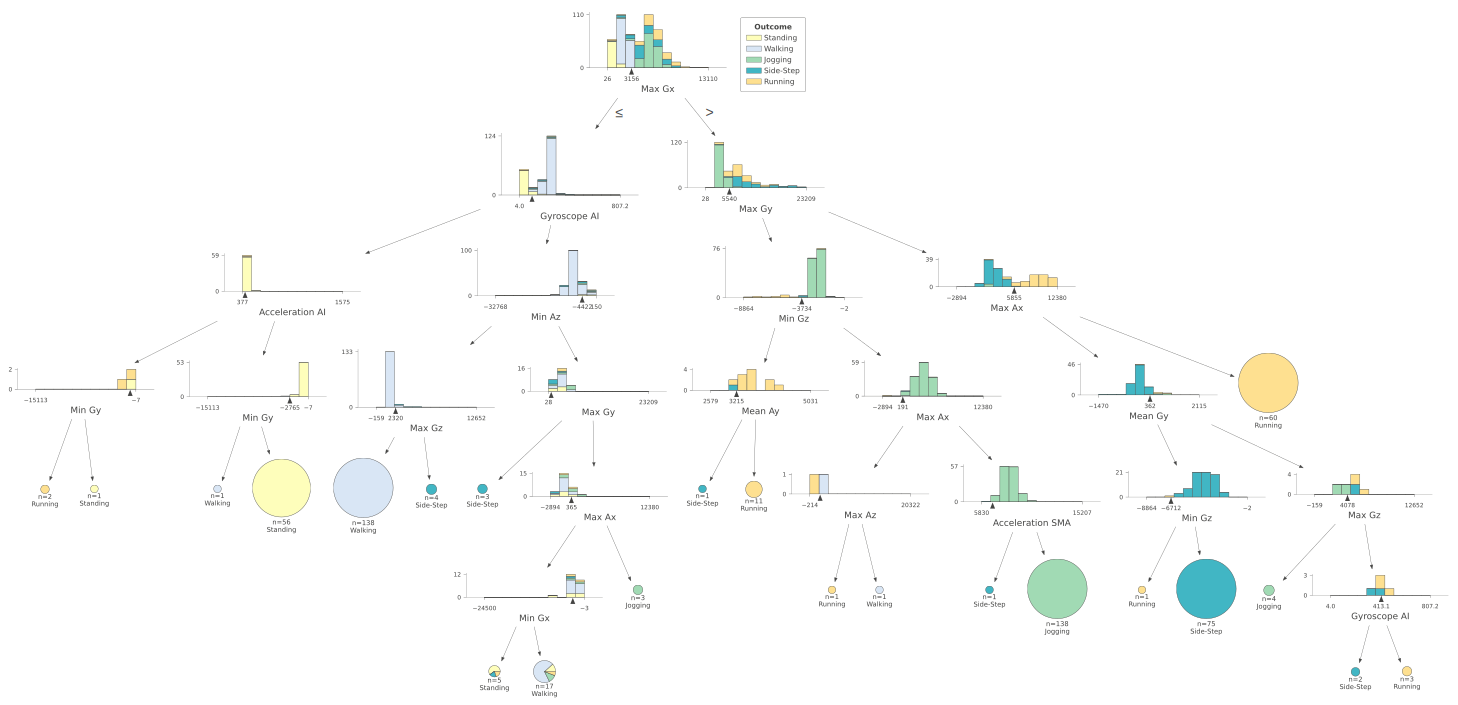

In [40]:
# visualise the best classifier using dtreeviz
c_names = {0:"Standing", 1:"Walking", 2:"Jogging", 3:"Side-Step", 4:"Running"}
f_names = ["Mean Ax", "Mean Ay", "Mean Az","Mean Gx", "Mean Gy", "Mean Gz",
           "Max Ax", "Max Ay", "Max Az","Max Gx", "Max Gy", "Max Gz", 
           "Min Ax", "Min Ay", "Min Az","Min Gx", "Min Gy", "Min Gz",
           "Acceleration SMA", "Gyroscope SMA" , "Acceleration AI", "Gyroscope AI"]

viz = dtreeviz.model(clf,
      np.array(X_train),
      np.array(y_train),
      target_name ='Outcome',
      feature_names = f_names,
      class_names = c_names
      )
viz.view()